# **STANLEY Tutorial — Kepler-47 (Local, Small-Grid Run)**
---

# **Background: Kepler-47**

**Kepler-47** is a landmark circumbinary system containing **three confirmed planets**: Kepler-47b, Kepler-47c, and Kepler-47d. Kepler-47b remains the **smallest circumbinary planet known**, while Kepler-47c was discovered later as the middle planet and Kepler-47d is the outermost companion. The host is an **eclipsing binary** with an orbital period of **≈ 7.45 days**.

In this tutorial, we focus on the **inner planet Kepler-47b**, although **STANLEY** has demonstrated the ability to recover **all three planets** in this system. The host binary’s strong intrinsic variability and orbital motion produce complex transit signatures characterized by:

- Significant **transit timing variations (TTVs)**
- Significant **transit duration variations (TDVs)**
- Transit shapes that differ strongly from single-star systems
- Light curves shaped by eclipses, ellipsoidal modulation, and binary motion

**STANLEY** was originally engineered to search **Kepler** photometry for circumbinary planets and was later expanded to handle **TESS**. This tutorial presents the pipeline in its **full, unfiltered form**.

To allow a fast, notebook-friendly runtime, we use a **narrow, prior-informed period window** centered on the known orbital period of Kepler-47b:

- **MinValue = 40 days**
- **MaxValue = 60 days**

This constrained window enables a complete demonstration of detrending, search, and diagnostic analysis **without requiring HPC resources**.

> **Note:**  
> Even this restricted brute-force search can take over **1 hour** on a standard laptop.  
>
> For any **broad or fully blind circumbinary search** (especially with wide period or parameter grids) we strongly recommend running STANLEY on an **HPC cluster**, as full searches are computationally intensive.

---


## **Import packages and STANLEY modules**


In [1]:
from stanley_cbp import stanley_detrending, SFP, stanley_analysis 
from IPython.display import Image, display
import os
import numpy as np
import matplotlib.pyplot as plt
import uuid
from argparse import Namespace
from stanley_cbp import Stanley_Functions as AC
import pandas as pd

---
# **Detrending**

This notebook mirrors the structure of the cluster detrending workflow, but reorganized for clarity and interactivity in a teaching environment. The detrending stage is essential for removing binary-driven variability, instrumental systematics, and common Kepler artifacts before performing a circumbinary planet search.

**Goals of this section**
- Discuss and demonstrate the capabilities of STANLEY's detrending module.
- Highlight the **key diagnostic figures** produced by the pipeline, including:
  - Raw light curve
  - Eclipse-fitting diagnostics
  - Final detrended light curve used for searching

Notebook conventions
- Internal timing uses **seconds**, while plotted results are shown in **days**.
- All output files are written to:
  - `LightCurves/Data_Preparation/<DetrendingName>/`
  - `LightCurves/Figures/<DetrendingName>/`
- This tutorial displays only the **most informative figures**, not every intermediate diagnostic.


## Configuration: STANLEY Detrending Module

The detrending stage in this notebook is a thin, notebook-friendly wrapper around the full **cluster version** of the STANLEY detrending code.

In the original cluster workflow, detrending is driven by command-line arguments and internal switches (see `runDetrendingModule` in `Stanley_Detrending.py`). Here, the same functionality is exposed through a single Python function call with explicit keyword arguments.


### Core inputs

- **`SystemName`** *(str)*  
  Target identifier, e.g. `"KIC10020423"`.

- **`DetrendingName`** *(str)*  
  Short run label used for naming figures and processed files.

- **`UseSavedData`** *(0 or 1)*  
  - `0` → force fresh downloads and processing  
  - `1` → reuse cached light curves and intermediates

These map directly to the cluster script’s `--systemName`, `--detrendingName`, and `--useSavedData`.


### Detrending feature switches

These Boolean flags control which detrending steps are applied. For this Kepler-47 tutorial, the configuration is:

- `detrending_quadratic`  
Remove broad quadratic trends (default for TESS; **disabled for this Kepler example**).
- `detrending_iterativeCosine`  
Iterative cosine (cofiam-like) removal of periodic systematics (**enabled**).
- `detrending_plugHoles`  
Fill large gaps before variable-window detrending (**disabled**).
- `detrending_variableDuration`  
Variable-duration biweight detrending (**disabled**).
- `detrending_sineFit`  
  Chunked sine detrending using the dominant period (**disabled**).
- `detrending_removeKinks`  
Identify/correct jump-like artifacts (**enabled**).
- `detrending_removeCommonFalsePositives`  
Remove catalogued false positives (**enabled**).
- `detrending_findPotentialLedges`  
Flag possible ledges (**enabled**).
- `detrending_findDeepestPoints`  
Report deepest individual points (**enabled**).
- `detrending_plotSpecificTimes`  
Plot manually selected windows (**disabled**).
- `detrending_saveProcessedLightCurve`  
Save the final detrended light curve to `LightCurves/Processed/...  (**enabled**).
- `detrending_variableDurationXiTest`  
Diagnostic mode (**disabled**).
- `detrending_testCosine`  
Diagnostic mode (**disabled**).


### Injection and binary-physics options

For completeness, STANLEY also supports:

- **`detrending_injectTransits`** *(bool)*  
  If `True`, injects synthetic transits (please see the KeplerInjectionTutorial Jupyter Notebook)

- **`injection_param_file`** *(str or None)*  
  CSV defining injection parameters.

- **`detrending_ellipsoidal`** *(bool)*  
  Fit/remove ellipsoidal modulation at 2× the binary frequency (**disabled**).

- **`detrending_reflection`** *(bool)*  
  Fit/remove reflection/heating signals at 1× the binary frequency (**disabled**).

In this tutorial, both injections and binary-physics removals are **off**, consistent with typical Kepler detrending where iterative-cosine alone is effective. The binary-physics detrending is considered supplemental to the default iterative-cosine and should only be turned on should a target exhibit strong periodic modulation consistant with ellipsoidal or reflective effects.

### Plotting and binning behavior

- `_plot_trends` — Whether trend models and intermediate diagnostics are displayed (**enabled**).
- `_show_plots` — Whether plots are shown inline (**enabled**).
- `bin_width`, `min_points_per_bin`, `gap_threshold` — Control time binning and gap-handling (left at defaults for Kepler).

All detrended light curves and multi-stage diagnostic figures are written to:

- `LightCurves/Data_Preparation/<DetrendingName>/`
- `LightCurves/Figures/<DetrendingName>/`
- `LightCurves/Processed/<DetrendingName>/`

The notebook sets these using simple Python variables instead of command-line flags, but the underlying pipeline behavior matches the full cluster detrending script.


In [2]:
# Inputs & run label
SystemName = "KIC10020423" # KIC or TIC + # (if no mission is provided, STANLEY assumes KIC)
mission = "KIC" # "KIC" or "TIC"
ID = 10020423
DetrendingName = "Kepler47Detrending" # short label for figures/files
UseSavedData = 0 # 1=use cached intermediates if available, 0=fresh

# Feature switches
detrending_quadratic = False
detrending_iterativeCosine = True
detrending_plugHoles = False
detrending_variableDuration = False
detrending_sineFit = False
detrending_removeKinks = True
detrending_removeCommonFalsePositives = True
detrending_findPotentialLedges = True
detrending_findDeepestPoints = True
detrending_plotSpecificTimes = False
detrending_saveProcessedLightCurve    = True
detrending_variableDurationXiTest = False
detrending_testCosine = False
detrending_injectTransits = False

# TESS targets had more variable data, iterative cosine seems to be sufficient for Kepler data
detrending_ellipsoidal = False
detrending_reflection  = False

# Plot behavior
_plot_trends = True
_show_plots = True


## Running the detrending module

`runDetrendingModule()` automatically generates a variety of diagnostic figures at each stage of the pipeline.

In this tutorial, we will:
- Let STANLEY save all figures to disk as usual.
- **Explicitly display only a curated subset of plots inline**, loading them from the output directories.

After the detrending finishes, we will focus on:

1. The **raw, sector-by-sector light curve** before any processing.  
2. The **phase-folded light curve before and after eclipse removal**.  
3. A **periodogram panel** summarizing how the detrending stages affect the frequency content.  

In [3]:
# We are not running injections at this point, see injection tutorial for more specifics
injection_csv = None

# Build kwargs from the feature switches defined in the previous cell
kwargs = dict(
    SystemName=SystemName,
    DetrendingName=DetrendingName,
    UseSavedData=UseSavedData,

    detrending_quadratic=detrending_quadratic,
    detrending_iterativeCosine=detrending_iterativeCosine,
    detrending_plugHoles=detrending_plugHoles,
    detrending_variableDuration=detrending_variableDuration,
    detrending_removeKinks=detrending_removeKinks,
    detrending_removeCommonFalsePositives=detrending_removeCommonFalsePositives,
    detrending_findPotentialLedges=detrending_findPotentialLedges,
    detrending_findDeepestPoints=detrending_findDeepestPoints,
    detrending_plotSpecificTimes=detrending_plotSpecificTimes,
    detrending_saveProcessedLightCurve=detrending_saveProcessedLightCurve,
    detrending_variableDurationXiTest=detrending_variableDurationXiTest,
    detrending_testCosine=detrending_testCosine,
    detrending_injectTransits=detrending_injectTransits,

    detrending_ellipsoidal=detrending_ellipsoidal,
    detrending_reflection=detrending_reflection,

    _plot_trends=_plot_trends,
    _show_plots=_show_plots,
)

# Only attach the CSV arg if injections are enabled *and* you provided a filename
if detrending_injectTransits and injection_csv:
    kwargs["injection_param_file"] = injection_csv

# Fire the pipeline
res = stanley_detrending.runDetrendingModule(**kwargs)

print("Detrending finished.\nSummary:")
for k, v in res.items():
    print(f"  {k}: {v}")

----- RUNNING DETRENDING CODE -----
System Name = KIC10020423
KIC = 10020423
Detrending Name = Kepler47Detrending
----- DETRENDING SETTINGS -----
Quadratic = False
Iterative Cosine = True
Variable Biweight = False
Sine Fit = False
Plug Holes = False
Remove Common False Positives = True
Remove Kinks = True
Remove Common False Positives = True
Find Potential Ledges = True
Find Deepest Points = True
Plot Specific Times = False
Save Processed Light Curve = True
Variable Duration Xi Test = False
Test Cosine = False
Inject Transits = False
Ellipsoidal Detrending = False
Reflection Detrending = False
----- LOADING SYSTEM -----
Searching for orbit data in Villanova catalog
Orbit data found from Villanova catalog
Secondary eclipse found, calculating eccentricity and omega
Searching for stellar data in Windemuth catalog
Stellar data found in Windemuth catalog
[saved] C:\Users\tklea\TESSCBP\PUBLIC_RELEASE_STANLEY\Tutorials\LightCurves\Figures\Kepler47Detrending\KIC_10020423_phase_folded_original_

---
## **Detrending Diagnostics**

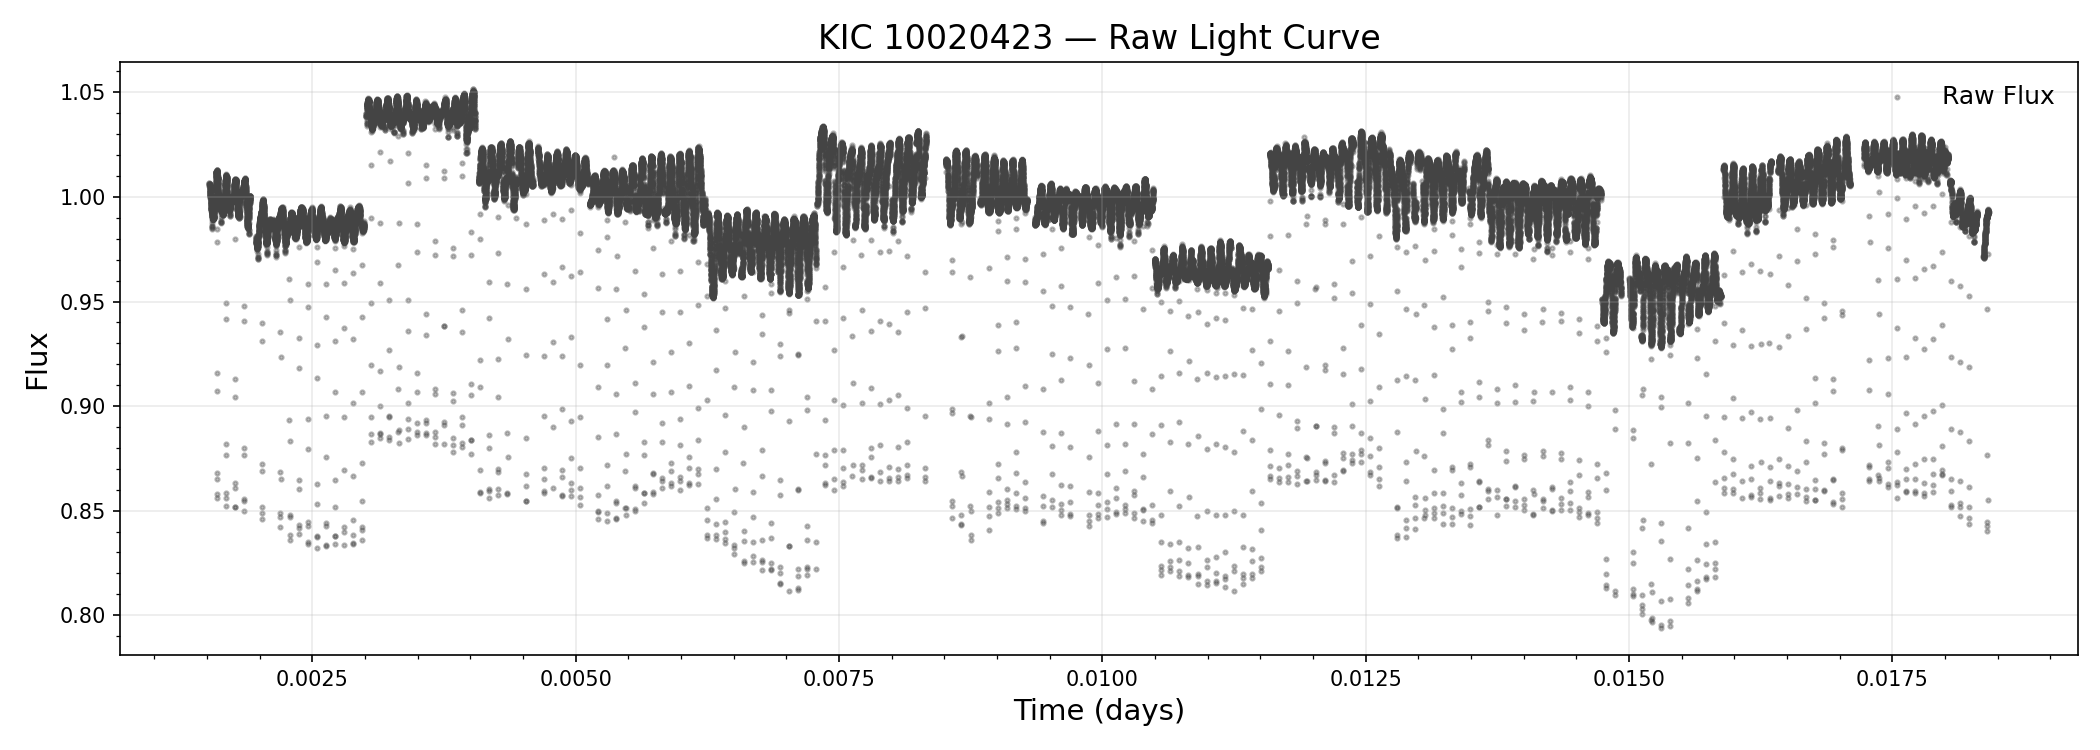

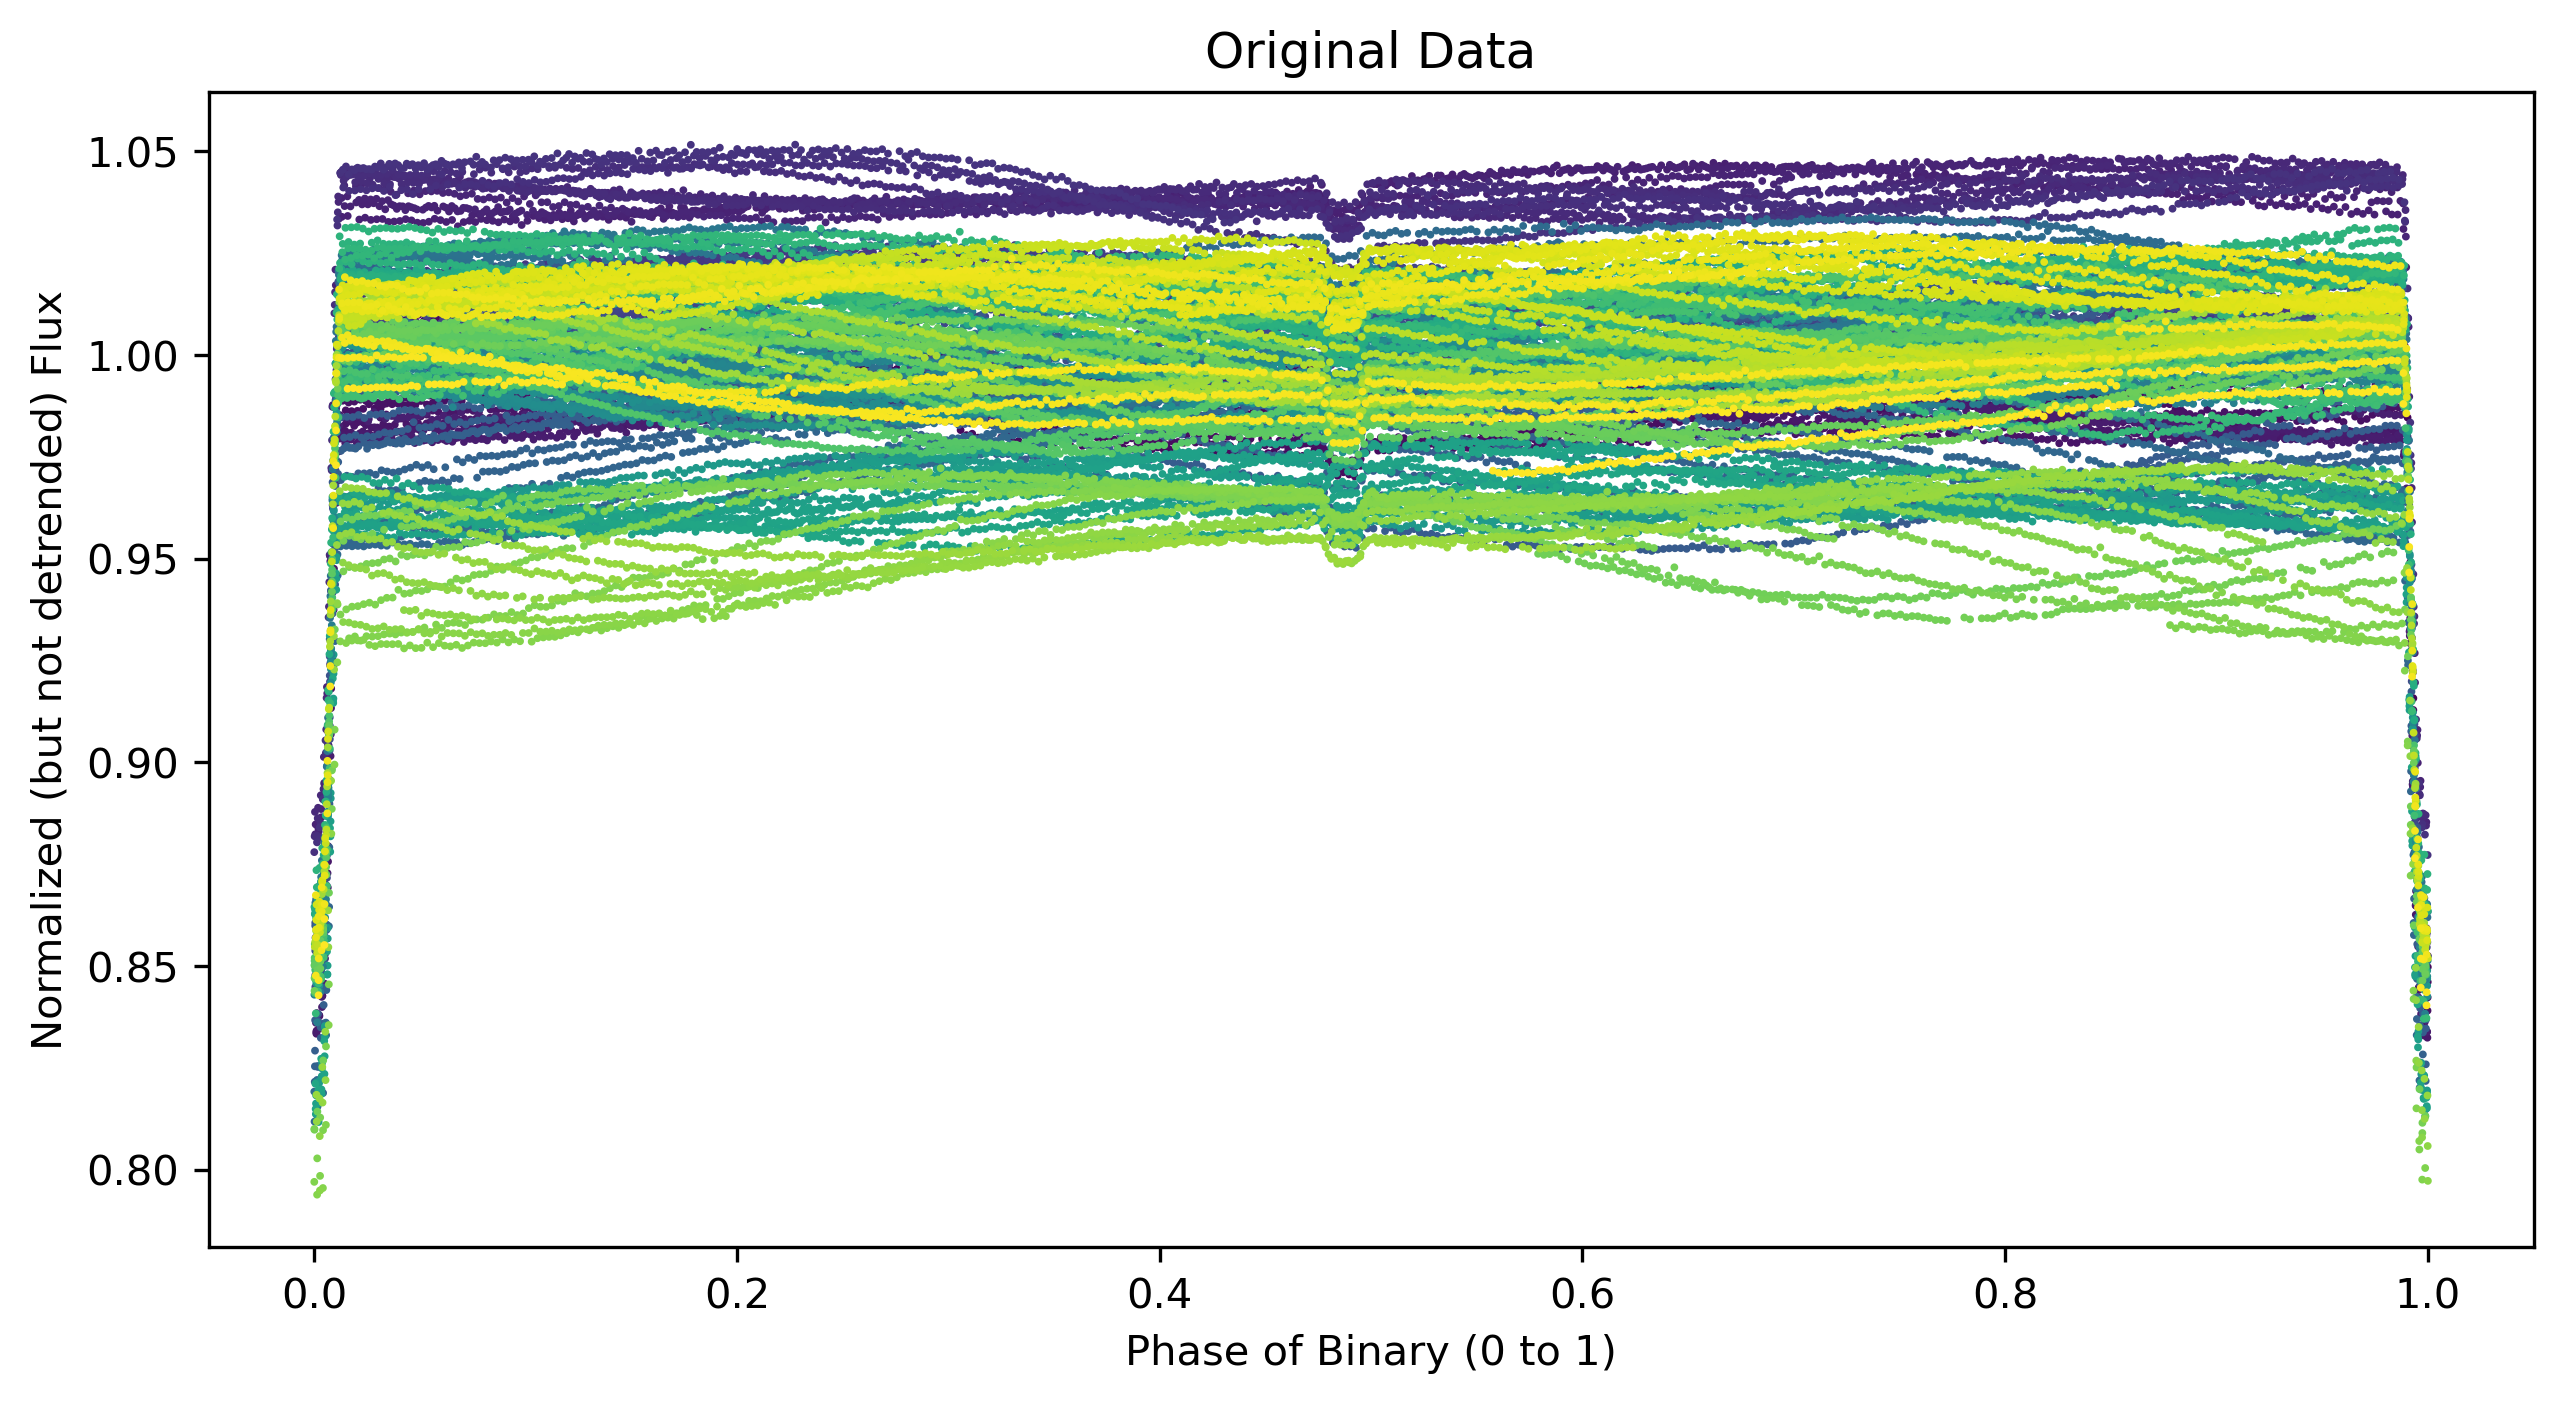

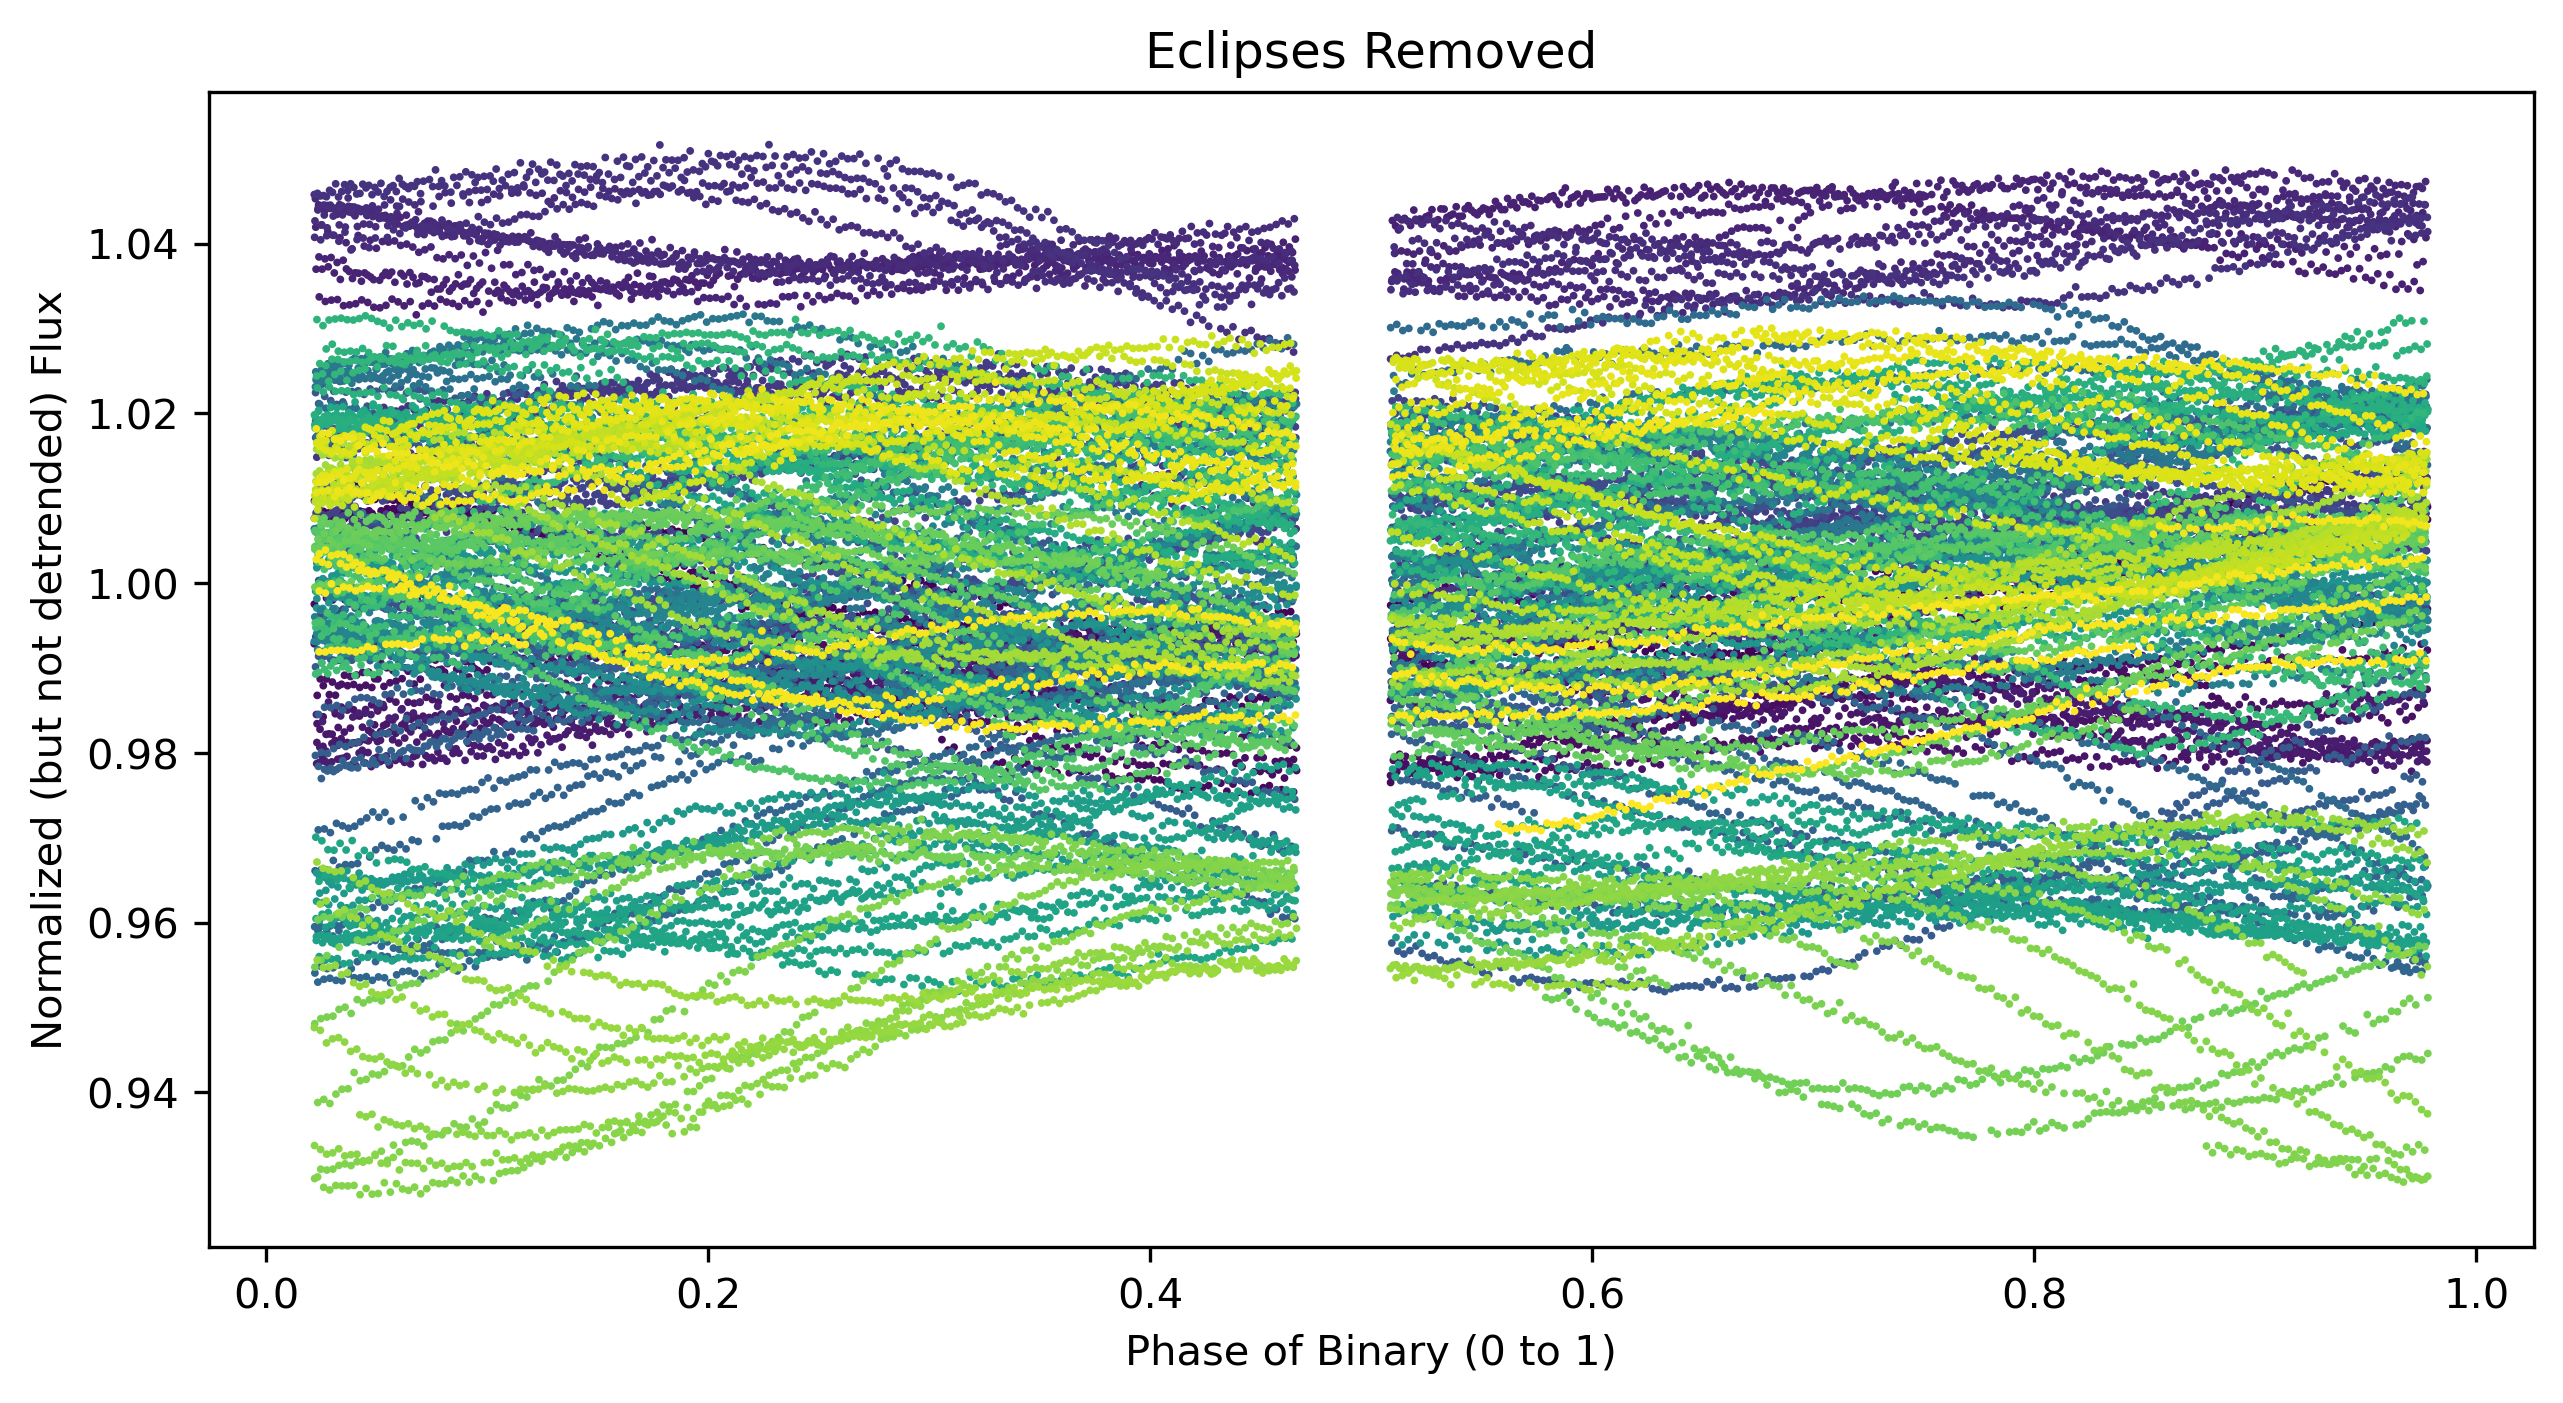

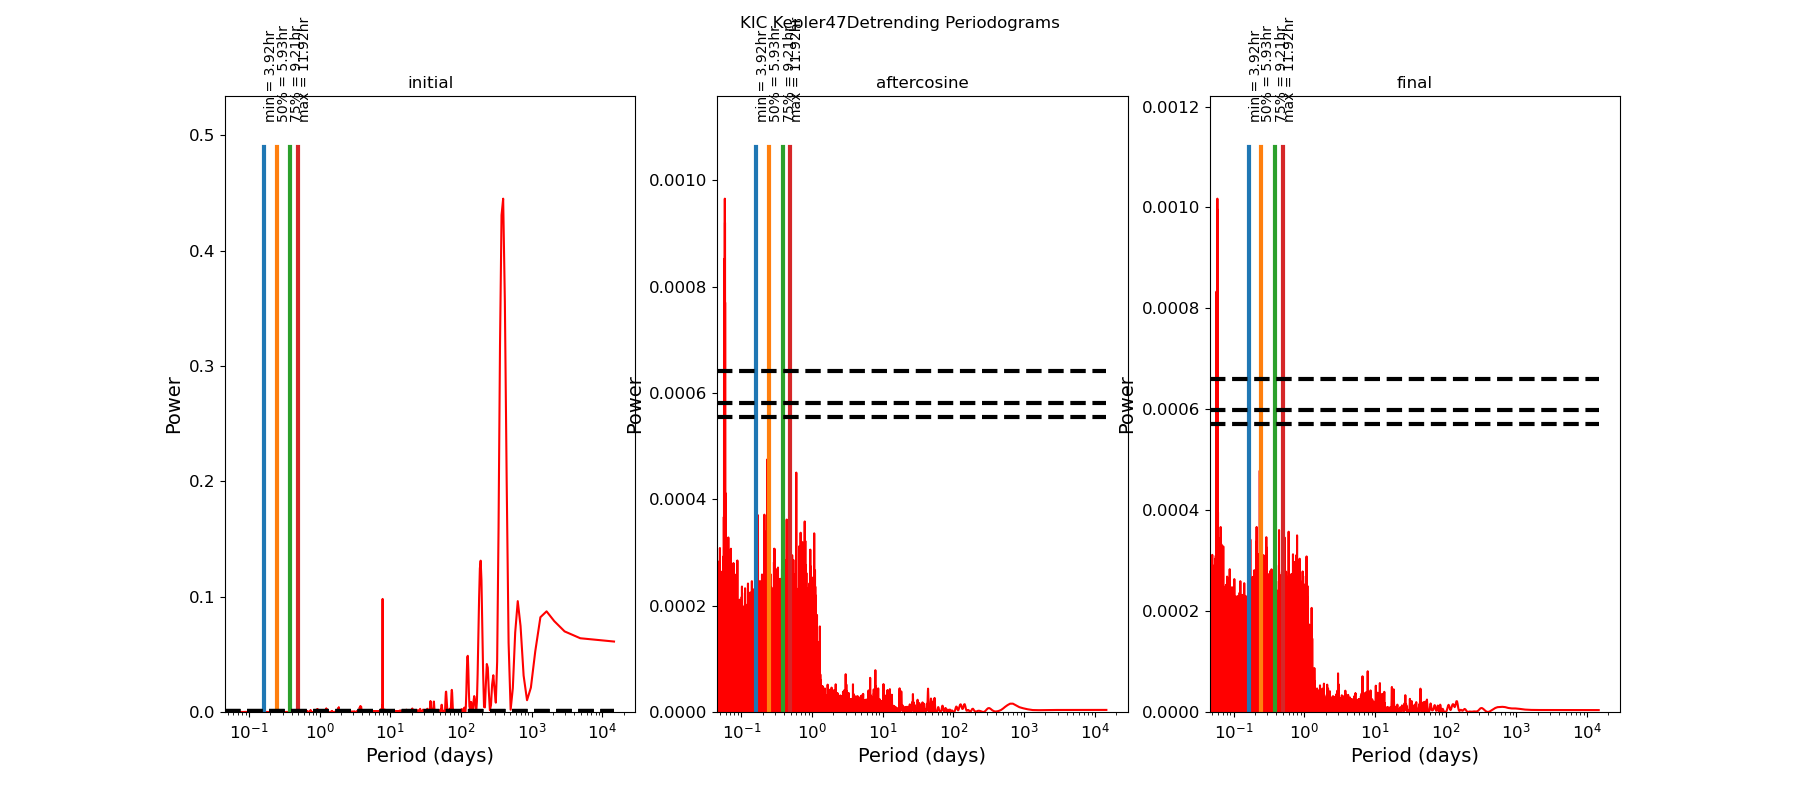

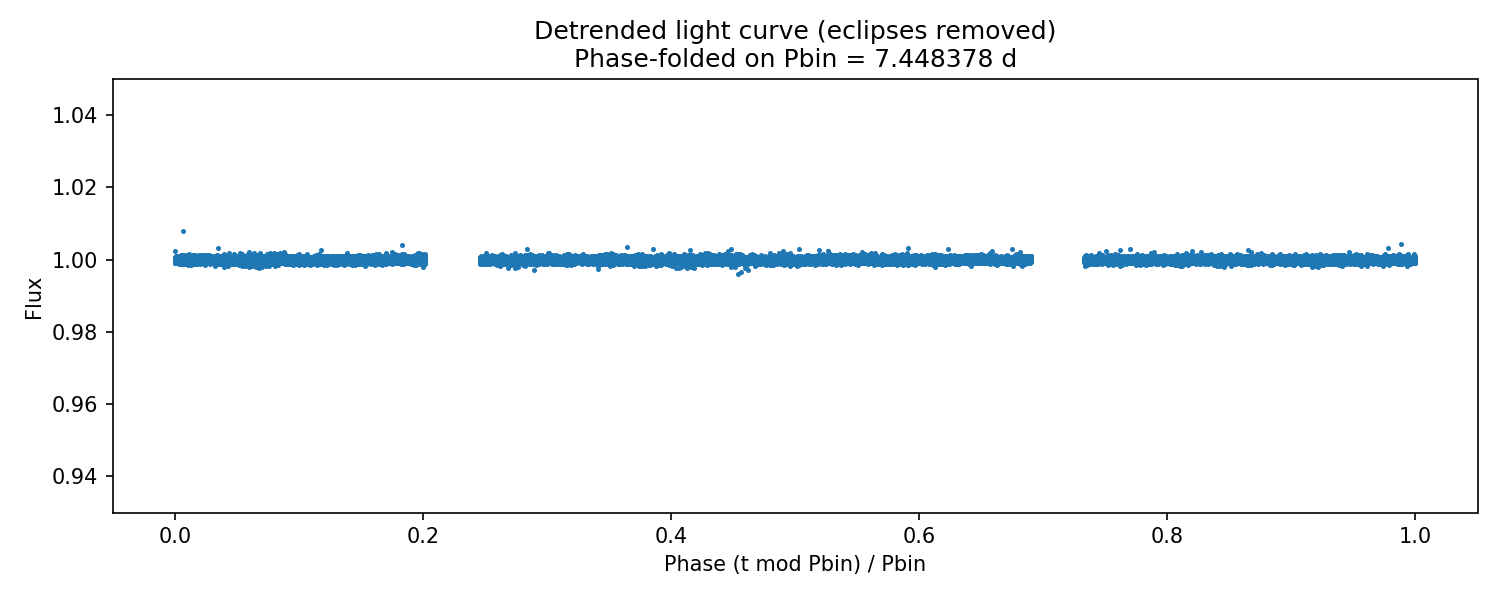

In [4]:
# Paths
fig_dir = os.path.join("LightCurves", "Figures", DetrendingName)
data_prep = os.path.join("LightCurves", "Data_Preparation", DetrendingName)
raw_dir = os.path.join("LightCurves", "Raw")
raw_file = os.path.join(raw_dir, f"{ID}_raw.csv")

print("\nPlotting raw light curve:\n")

if os.path.exists(raw_file):

    # Load whitespace-delimited: [time_sec, flux, flux_err]
    raw = np.genfromtxt(raw_file)
    if raw.ndim == 1:
        raw = raw.reshape(1, -1)

    time_sec  = raw[:, 0]
    flux_raw  = raw[:, 1]
    time_days = time_sec / 86400.0

    # Make sure folder exists for the temp file
    os.makedirs(data_prep, exist_ok=True)
    tmp_png = os.path.join(data_prep, f"{mission}_{ID}_raw_lightcurve_tmp_{uuid.uuid4().hex}.png")

    # Plot layout
    plt.figure(figsize=(14, 5))

    plt.scatter(time_days, flux_raw, s=4, color="#444444", alpha=0.35, label="Raw Flux")

    plt.xlabel("Time (days)", fontsize=14)
    plt.ylabel("Flux", fontsize=14)
    plt.title(f"{mission} {ID} — Raw Light Curve", fontsize=16)

    plt.grid(True, alpha=0.25)
    plt.minorticks_on()
    plt.legend(frameon=False, fontsize=12)

    plt.tight_layout()
    plt.savefig(tmp_png, dpi=150)
    plt.close()

    print("Showing: raw light curve")
    display(Image(filename=tmp_png, width=950))

    # Remove temp file so it doesn't persist on disk, we are simply plotting for a visual diagnostic within the tutorial
    try:
        os.remove(tmp_png)
    except OSError:
        pass

else:
    print(f"Missing raw file: {raw_file}")

important_figs = [
    f"{mission}_{ID}_phase_folded_original_data.png",
    f"{mission}_{ID}_phase_folded_eclipses_removed.png",
    f"{mission}_{ID}_{DetrendingName}_periodograms.png",
]

print("\nDisplaying key diagnostic plots (in order):\n")

for fname in important_figs:
    # Look in Figures first, then Data_Preparation
    possible_paths = [os.path.join(fig_dir, fname), os.path.join(data_prep, fname),]
    
    displayed = False
    for path in possible_paths:
        if os.path.exists(path):
            print(f"Showing: {fname}")
            display(Image(filename=path, width=950))
            displayed = True
            break
    
    if not displayed:
        print(f"Missing: {fname}")

# Now, let's take a look at the detrended light curve with the eclipses removed
# This is what gets read into the search
detrended_dir = os.path.join("LightCurves", "Processed", DetrendingName)
detrended_path = os.path.join(detrended_dir, f"{mission}_{ID}_{DetrendingName}_detrended.csv")
detrended_lc = pd.read_csv(detrended_path, delim_whitespace=True)

# Load binary starting params (key,value CSV)
binaryParams_path = os.path.join(detrended_dir, f"{mission}_{ID}_{DetrendingName}_binaryStartingParams.csv")
binaryParams = pd.read_csv(binaryParams_path, header=None, names=["param", "value"])

# Extract period
period = binaryParams.loc[binaryParams["param"] == "Pbin (days)", "value"].iloc[0]
period = float(period) # make sure it's numeric

# Load in our detrended light curve time and flux
t = detrended_lc.iloc[:, 0].to_numpy()
f = detrended_lc.iloc[:, 1].to_numpy()

# Phase fold 
phase = (t % period) / period
# Sort by phase
order = np.argsort(phase)

# Plot detrended LC fed into the search
tmp_png = os.path.join(data_prep, f"{mission}_{ID}_{DetrendingName}_detrended_phasefolded_tmp_{uuid.uuid4().hex}.png")

plt.figure(figsize=(10, 4))
plt.scatter(phase[order], f[order], s=2)
plt.xlabel("Phase (t mod Pbin) / Pbin")
plt.ylabel("Flux")
plt.ylim(0.93, 1.05)
plt.title(
    f"Detrended light curve (eclipses removed)\n"
    f"Phase-folded on Pbin = {period:.6f} d"
)
plt.tight_layout()
plt.savefig(tmp_png, dpi=150)
plt.close()

print("Showing: detrended light curve (fed into search)")
display(Image(filename=tmp_png, width=950))

# Clean up temp file
try:
    os.remove(tmp_png)
except OSError:
    pass


---
## **Search**

`Stanley_FindPlanets()` performs the circumbinary planet search by forward modeling an N body grid of planetary orbits and comparing the resulting transit masks to the detrended light curve. For this Kepler 47 tutorial, the search is run in parallel across four sectors, using a period range tailored to the known orbital period of Kepler 47b.

The search proceeds as follows:

- It constructs a grid of **planetary orbital parameters**, including the orbital period *Pp*, eccentricity *ep*, argument of periastron *omegap*, and true anomaly *thetap*. The binary parameters were established during the detrending stage and remain fixed in this example.

- For each grid point, an **N body–based transit mask** is generated that predicts where transits should occur.

- Each mask is compared to the detrended light curve and assigned a **significance value σ**, indicating how well that planetary configuration explains the data. Interpolation between true anomaly samples is used when `N_interp > 1`.

- All σ grids and intermediate results are written to `PlanetSearchOutput/<SearchName>/` for later inspection and visualization.

In this Kepler 47 notebook, `Stanley_FindPlanets` is configured to balance speed and completeness, making it suitable for real time demonstration while still capturing the full circumbinary search behavior.

### **Notebook Search Configuration**

- `TotalSectors = 4`  
  The data are split into four sectors (quarters), each searched separately.

- `currentSector = 1`  
  The parallel launch executes the search across all four sectors.

- `parallel = 1`
Turns on parallel execution so multiple sectors (and/or trial periods, depending on how your wrapper is written) can be processed concurrently. If `parallel = 0`, the code runs in a single process. 

- `cpuCount = N`
Sets the number of CPU workers to use when `parallel = 1`. A good default is the number of physical cores you want to dedicate (e.g., `cpuCount = 4` on a laptop; larger on a node). If cpuCount is larger than what your machine/node actually allocates, you won’t get a speedup and may slow down due to overhead. If `cpuCount = 0` the code automatically uses all available CPU cores on the current machine or allocated node.

- `OnCluster = 0`  
  Enables local progress bar output.

- `N_interp = 2`  
  Enables light interpolation in true anomaly.

- `BoundsType = "days to days"`  
  The period grid is specified directly in days.

- `MinValue = 40`, `MaxValue = 60`  
  A **prior informed window** centered on the expected period of Kepler 47b. This significantly reduces runtime while retaining sensitivity to the planet.

- `e_max_planet = 0.0`  
  Planet eccentricity is fixed to zero for this demonstration.

As in the other tutorials, this step does not immediately plot diagnostics. Instead, it produces the complete high dimensional σ grid, which the analysis module will convert into SDE maps, candidate summaries, and final evaluation plots.

### **Tutorial Goals**

1. Verify that the Kepler 47 circumbinary search runs successfully in parallel across multiple sectors.  
2. Understand where outputs are stored and how they are used by the analysis stage.  
3. Use the resulting σ grids to examine the detectability of Kepler 47b within the constrained search window.


In [ ]:
TotalSectors = 4
OnCluster = 0
SearchName = 'Kepler47Search'
SystemName = SystemName
DetrendingName = DetrendingName
N_interp = 2
BoundsType = 'days to days'
MinValue = 40
MaxValue = 60
e_max_planet = 0.0

args = Namespace(
    searchName=SearchName,
    systemName=SystemName,
    detrendingName=DetrendingName,
    totalSectors=TotalSectors,
    currentSector=1,
    onCluster=OnCluster,
    parallel=1,
    cpuCount=0, # use all cpus available
    interpolationValue=N_interp,
    boundsType=BoundsType,
    minValue=MinValue,
    maxValue=MaxValue,
    e_max_planet=e_max_planet,
)

SFP.parallel(args)
print("Search finished for all sectors (parallel).")


---
## **Analysis**

After the search has completed, we call `runAnalysisModule` to turn the high-dimensional
search outputs into a small set of **human-interpretable diagnostics**.

Conceptually, `runAnalysisModule`:

- **Loads the search context and detrended light curve**  
  using the `simInfo` file, the saved detrended CSV associated with the same `DetrendingName`,
  and the binary starting parameters.

- **Reads and aggregates the search grids**  
  by loading the `searchParameters_array` and concatenating the
  `searchResults_array_*` files in `PlanetSearchOutput/<SearchName>/`
  across all θₚ sectors.

- **Builds a 1D detection statistic as a function of planet period**  
  by combining the multi-dimensional significance grid over the remaining
  parameters (masses, binary elements, eccentricity *eₚ*, argument of periastron *ωₚ*,
  and true anomaly *θₚ*), and then computing an SDE curve vs. period.

- **Selects the best-fit model at the SDE peak**  
  and extracts the corresponding `(Pₚ, eₚ, ωₚ, θₚ)` combination, along with the
  associated binary parameters.

- **Reconstructs transit times and durations** for the best-fit configuration  
  and generates:
  - A **TTV (Transit Timing Variations)** plot  
  - A **TDV (Transit Duration Variations)** plot  
  - A concise, human-readable summary text file  
  - Helper files with transit windows and discovered transit lists for downstream vetting.

This tutorial uses **four sectors** on the local notebook. We still call `runAnalysisModule` so the workflow matches the full multi-sector/cluster use case:

- The same analysis call works when `totalSectors > 1`.  
- The module automatically discovers and loads all sector outputs for `searchName` and `systemName`.  
- The returned `result` dictionary provides a compact summary (e.g., peak SDE value and best-fit period) that we can inspect directly in the notebook.


## Analysis

In [ ]:
# Run the analysis module to summarize results
result = stanley_analysis.runAnalysisModule(
    searchName=SearchName,
    systemName=SystemName,
    totalSectors=TotalSectors,
    currentSector=1,
    onCluster=OnCluster,
)

print("Analysis finished.")
print("Summary:")
for k, v in result.items():
    print(f"  {k}: {v}")


[2025-12-15 17:56:54.327436] Analysis expecting simInfo at: C:\Users\tklea\TESSCBP\PUBLIC_RELEASE_STANLEY\Tutorials\PlanetSearchOutput\Kepler47Search\KIC_10020423_simInfo.npy
Loading results for searchName = Kepler47Search, systemName = KIC10020423, detrendingName = Kepler47Detrending
4 sector(s) loaded
Create 1D SDE
[SDE diag] N=632 kept=609 (96.36%) initialSTD=0.892076 clipSTD=0.705589 denom=clipSTD max=8.440
[SDE] Max=8.440 at 49.56195 d
1D SDE created
Getting best fitting transit times
meanPlanetTransitInterval (sec): 4151303.5284191
scaledWindowTime size: 272, totalWindowFlux size: 272
meanScaledFlux_time size: 14, meanScaledFlux size: 14
sigma_solutionOld = 16.67423384231271
meanFlux_solution = -0.00048667357336032284
No known transits file found
Analysis finished.
Summary:
  status: ok
  mission: KIC
  ID: 10020423
  DetrendingName: Kepler47Detrending
  SDE_1d_max: 8.440338259727728
  period_sdeMax_days: 49.561954101065034
  TTV_png: C:\Users\tklea\TESSCBP\PUBLIC_RELEASE_STANLEY

---
## **Search & Analysis Diagnostics and Results**


Search and analysis diagnostic plots:

Showing: 10020423_KICSDEpaper.png


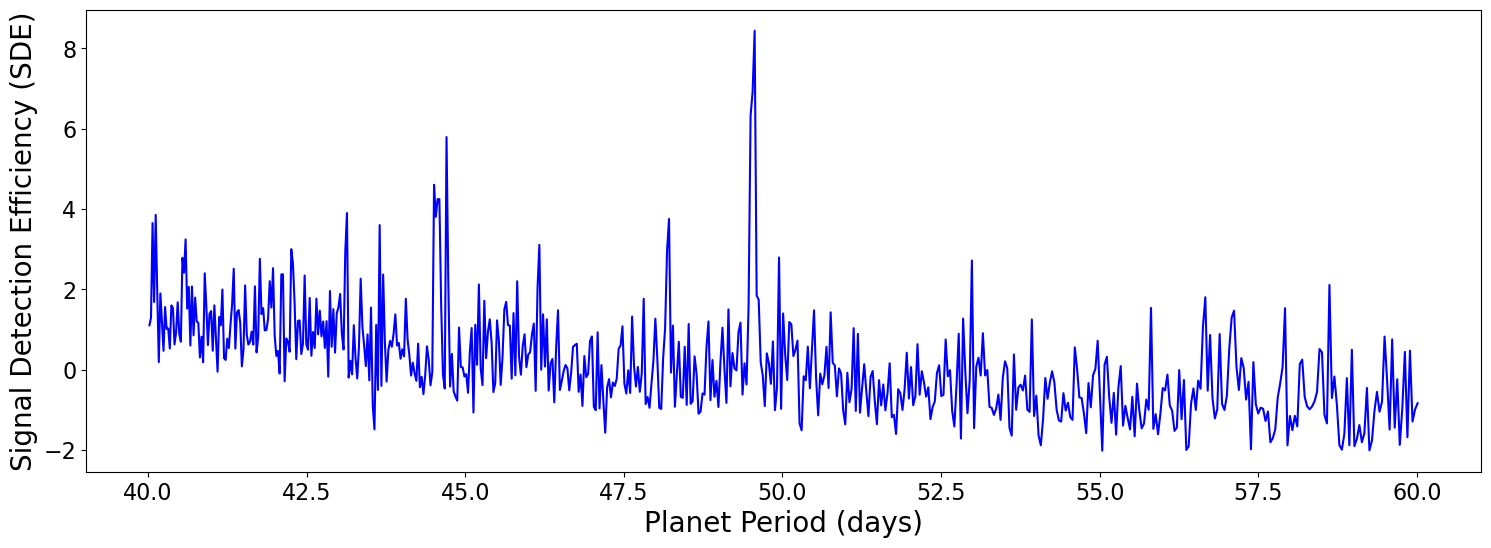

Showing: KIC_10020423_IndividualPlanetTransitsWiderWindow.png


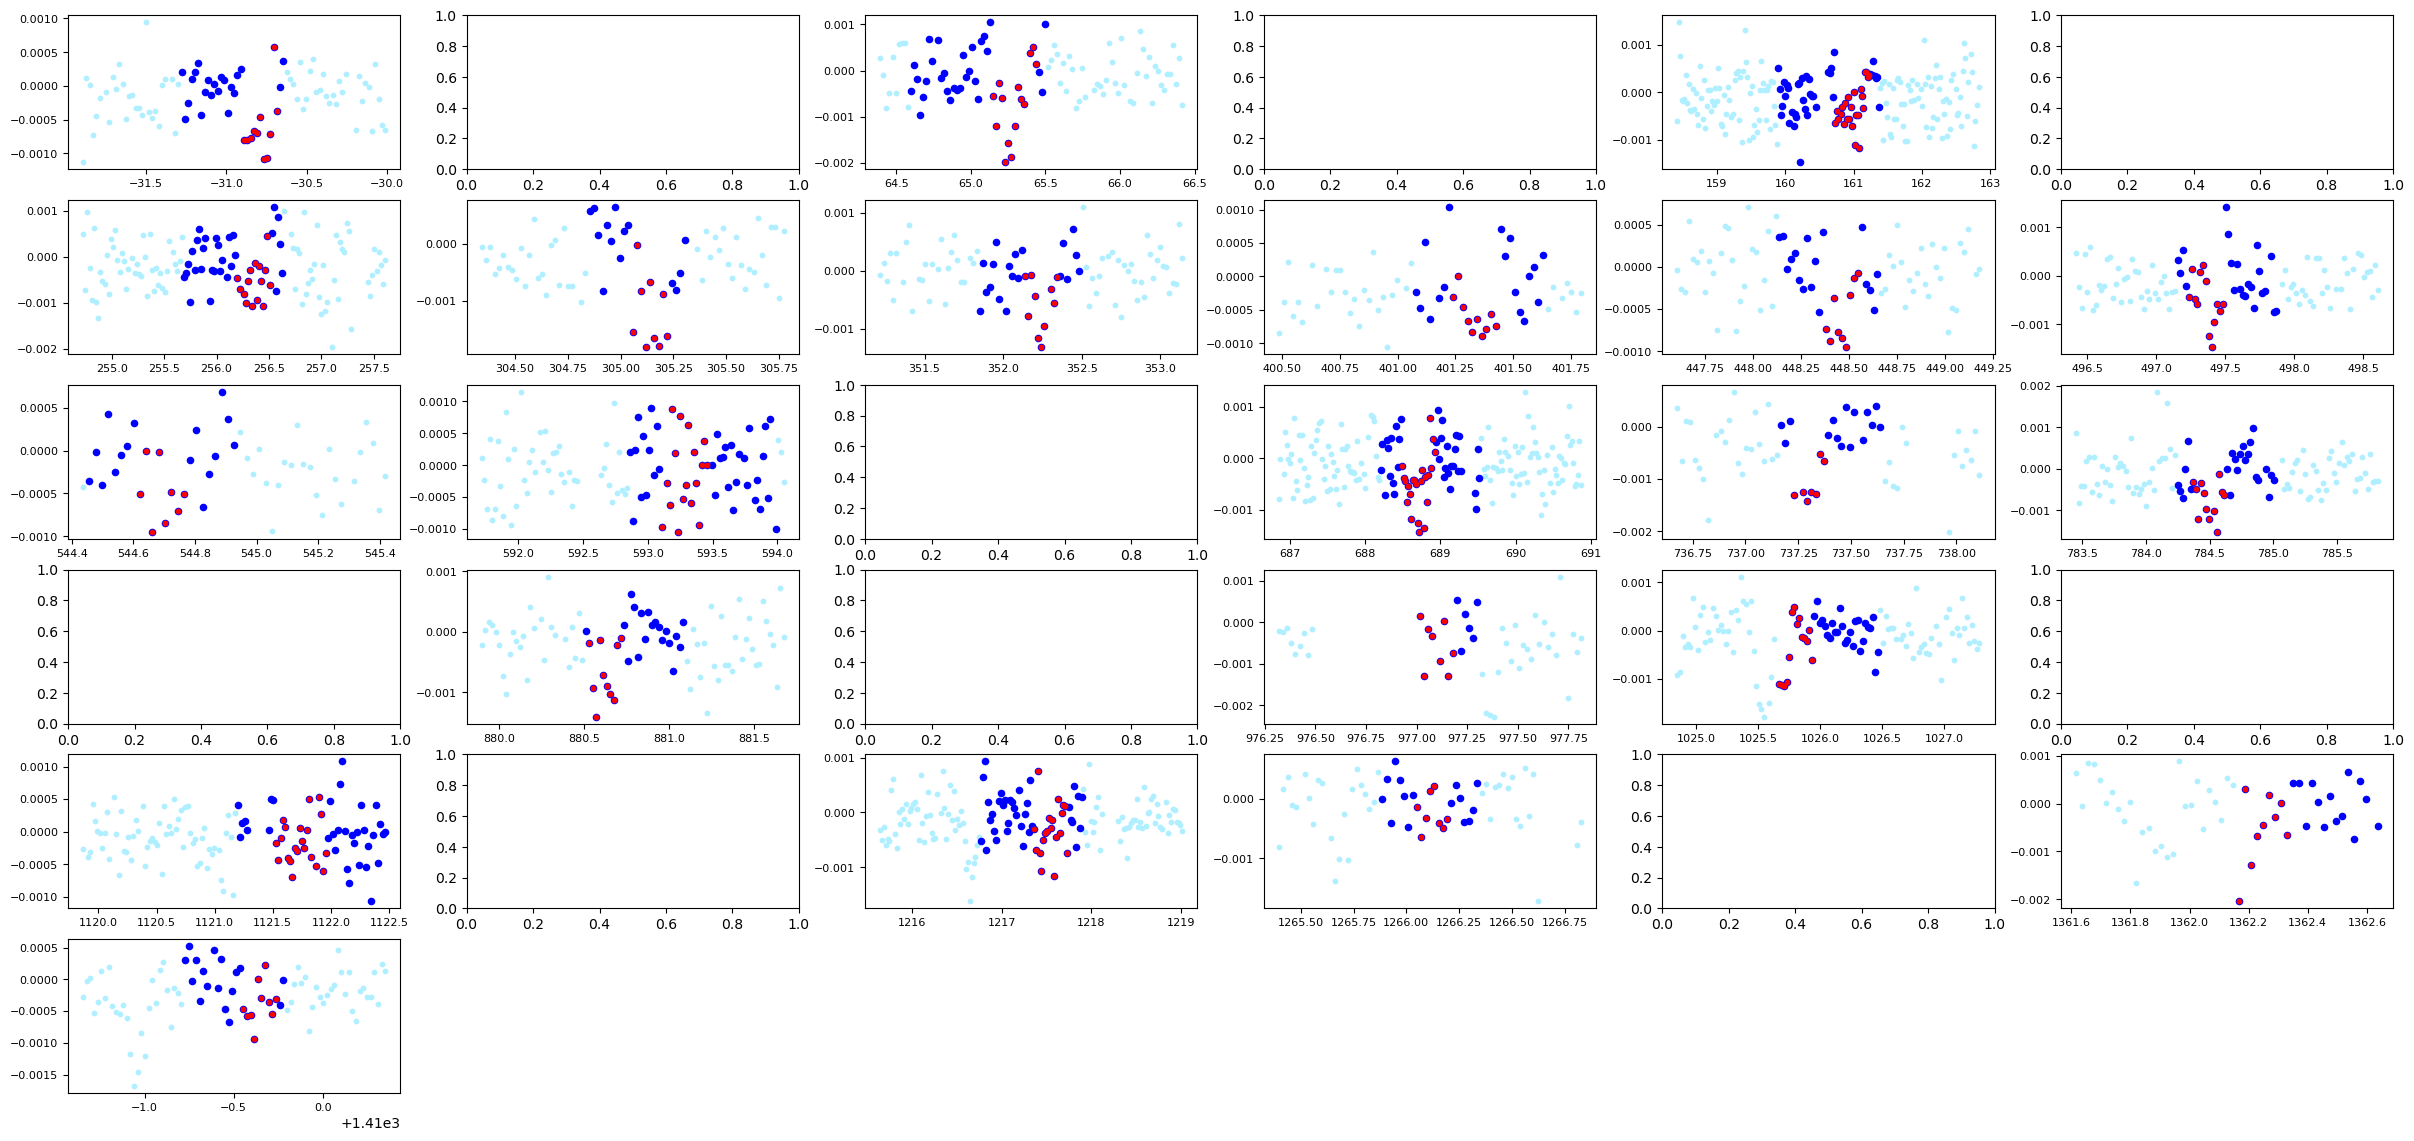

Showing: KIC_10020423_FoldedPlanetTransits.png


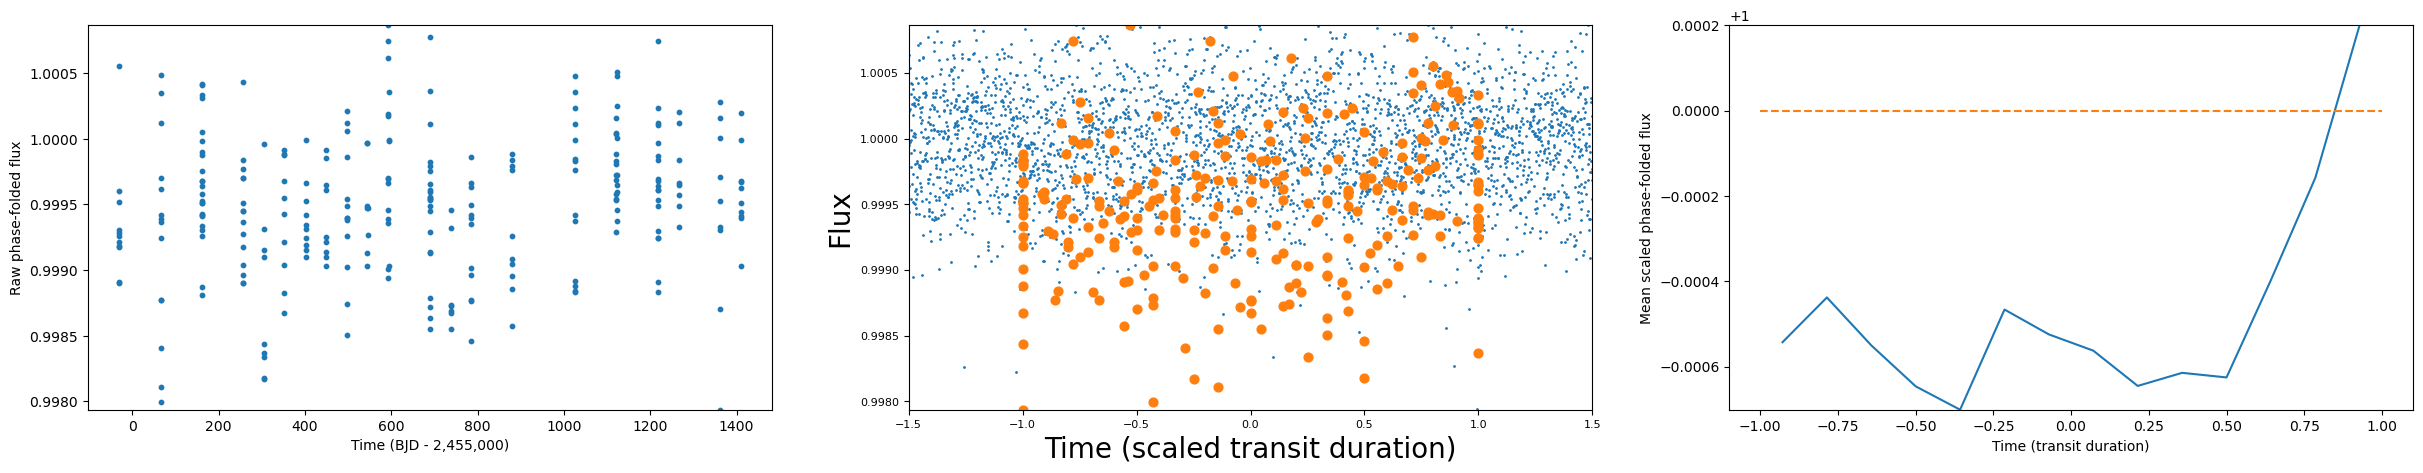



         Search Summary

System name                   : KIC10020423
mission + ID                  : KIC_10020423
Search name                   : Kepler47Search
Detrending name               : Kepler47Detrending
Total sectors                 : 4
Num Theta_p steps             : 123
Search parameter count        : 66503
SDE_1d (max value)            : 8.440338259727728
SDE_1d (period)               : 49.561954101065034
Pp (days)                     : 49.562 days
ep                            : 0.0
omegap (deg)                  : 0.0 deg
thetap (deg)                  : 61.7143 deg
Transit timing (best fit)     : -30.788, 16.0, 65.287, 112.0, 160.988, 209.0, 256.36, 305.139, 352.236, 401.333, 448.463, 497.36, 544.692, 593.291, 641.0, 688.709, 737.309, 784.492, 834.0, 880.622, 930.0, 977.096, 1025.801, 1073.0, 1121.734, 1170.0, 1217.543, 1266.122, 1313.0, 1362.249, 1409.646

Done.


In [ ]:
# Display and interpret our search results
fig_dir = os.path.join("PlanetSearchOutput", SearchName)

# Note that an SDE value of above 8 is considered a detection
analysis_figs = [
    f"{ID}_{mission}SDEpaper.png",
    f"{mission}_{ID}_IndividualPlanetTransitsWiderWindow.png",
    f"{mission}_{ID}_FoldedPlanetTransits.png",
]

print("\nSearch and analysis diagnostic plots:\n")

for fname in analysis_figs:
    path = os.path.join(fig_dir, fname)
    if os.path.exists(path):
        print(f"Showing: {fname}")
        display(Image(filename=path, width=950, height=400))
    else:
        print(f"Missing: {fname}")


results_file = os.path.join(fig_dir, f"{mission}_{ID}_SearchResults.txt")

print("\n\n==============================")
print("         Search Summary")
print("==============================\n")

if not os.path.exists(results_file):
    print(f"SearchResults file missing: {results_file}")
else:
    summary = {}
    with open(results_file, "r") as f:
        for line in f:
            if "=" in line:
                k, v = line.strip().split("=", 1)
                summary[k.strip()] = v.strip()

    keys_to_show = [
        "System name",
        "mission + ID",
        "Search name",
        "Detrending name",
        "Total sectors",
        "Num Theta_p steps",
        "Search parameter count",
        "SDE_1d (max value)",
        "SDE_1d (period)",
        "Pp (days)",
        "ep",
        "omegap (deg)",
        "thetap (deg)",
        "Transit timing (best fit)"
    ]

    for k in keys_to_show:
        print(f"{k:30s}: {summary.get(k, '---')}")

print("\nDone.")

---
## **Interpretation**

This tutorial demonstration successfully executed the full STANLEY circumbinary pipeline, from detrending through the planet search and post-search analysis, on the well-studied circumbinary system **Kepler-47 (KIC 10020423)**.

### Key outcomes

- **Detrending completed successfully**, producing a clean, binary-corrected Kepler light curve suitable for circumbinary transit searches.

- The planet search evaluated **66,503 parameter combinations** distributed across a grid of *(Pₚ, θₚ, eₚ, ωₚ)* using **123 θₚ samples**.

- The **1D SDE curve** showed a **clear peak** within the narrow demonstration window:  
  - **SDE\_max ≈ 8.44**  
  - **Peak period ≈ 49.56 days**

- The **best-fit model parameters** recovered from the grid were:

  - **Binary:**  
    - $m_A \approx{0.894} M_{\odot}$
    - $m_B \approx{0.334} M_{\odot}$
    - $P_{\text{bin}} = 7.448 \text{ days}$ 
    - $e_{\text{bin}} = 0. 0241,\text{ } \omega_{\text{bin}} = 215.4^{\circ}$

  - **Planet model selected by the grid:**
    - $P_p \approx{49.56} \text{ days} $
    - $e_p \approx{0}, \text{ } \omega_{p} = 0^{\circ}$ 
    - $\theta_p \approx{61.71^{\circ}}$

  *(Note: These are the best-fit values within the restricted grid chosen for tutorial speed, not a scientific refit of Kepler-47b.)*

- **Predicted mid-transit times** (best-fit model) were generated.  


### What this means

This notebook has demonstrated the **complete STANLEY workflow** in a compact, notebook-friendly setting:

1. High-quality detrending tailored to eclipsing binaries.  
2. A restricted but fully functional circumbinary planet search.  
3. Construction of the 1D SDE curve and extraction of the highest-scoring model.  
4. Generation of predicted transit ephemerides for the best-fit configuration.  
5. Creation of summary files and plots for downstream interpretation.

Although this tutorial was **not intended to re-discover Kepler-47b**, the pipeline correctly
identifies a strong, self-consistent solution within the prior-informed period window and
demonstrates the mechanism by which STANLEY searches for circumbinary planets.

You can now extend this tutorial by:

- widening the period bounds  
- enabling transit injections for completeness tests  
- increasing θₚ resolution  
- running multi-quarter analyses  
- performing full Kepler-scale CBP searches on a cluster or HPC environment  

This concludes the tutorial demonstration of the **STANLEY circumbinary planet pipeline** for **Kepler-47**.

